In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Loading


In [2]:
observed_npp = xr.open_zarr("./products/Hot_observed_npp.zarr")
observed_npp= observed_npp["l12"]
observed_npp.load()


<xarray.DataArray 'l12' (time: 8977, latitude: 1, longitude: 1)> Size: 72kB
array([[[183.4949276 ]],

       [[186.56237688]],

       [[182.15172717]],

       ...,

       [[327.72457179]],

       [[326.50529436]],

       [[334.47255167]]])
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 72kB 1998-01-01 1998-01-02 ... 2022-07-30
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS)
    station:  hot
    type:     in situ
    units:    mg m-2 day-1

# Climato


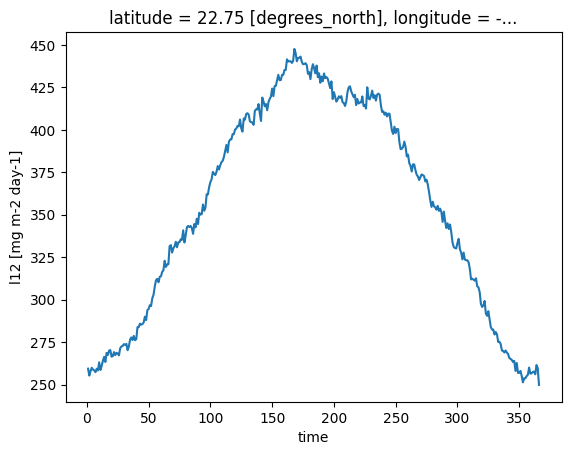

In [3]:
# Convert time to day of year
observed_npp['dayofyear'] = observed_npp['time'].dt.dayofyear

# Group by day of year and calculate the mean
climatology = observed_npp.groupby('dayofyear').mean(dim='time')

climatology.plot()

# Lowess


First we duplicate before and after the time series to make the lowess smoother.


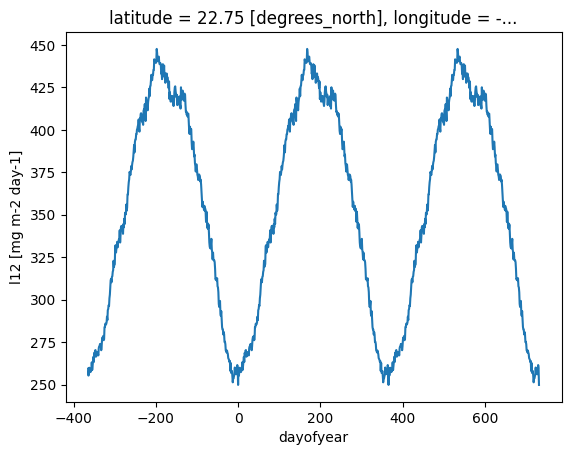

In [4]:
climatology_lower = climatology.assign_coords({"dayofyear": climatology.dayofyear - 366})
climatology_upper = climatology.assign_coords({"dayofyear": climatology.dayofyear + 366})
climatology = xr.concat([climatology_lower, climatology, climatology_upper], dim="dayofyear")
climatology.plot()

Then apply lowess.


In [5]:
climatology_lowess = lowess(
    climatology.values.flatten(),
    climatology['dayofyear'].values.flatten(),
    frac=0.05,
)
climatology_l12_lowess_0_05 = climatology.copy()
climatology_l12_lowess_0_05.data = climatology_lowess[:, 1].reshape(climatology.shape)
climatology_l12_lowess_0_05 = climatology_l12_lowess_0_05.sel(dayofyear=slice(1, 365))
climatology_l12_lowess_0_05.attrs["desc"] = "L12 multiplied by ZEU (from CMEMS) with LOWESS filter using frac=0.05"
climatology = climatology.sel(dayofyear=slice(1, 365))
climatology = xr.Dataset({"l12": climatology, "l12_lowess_0.05": climatology_l12_lowess_0_05})
climatology

<xarray.Dataset> Size: 9kB
Dimensions:          (latitude: 1, longitude: 1, dayofyear: 365)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * dayofyear        (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    l12              (dayofyear, latitude, longitude) float64 3kB 259.4 ... 2...
    l12_lowess_0.05  (dayofyear, latitude, longitude) float64 3kB 259.3 ... 2...

In [6]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add l12 trace
fig.add_trace(go.Scatter(x=climatology_df['dayofyear'], y=climatology_df['l12'], mode='lines', name='L12'))

# Add l12_lowess_0.05 trace
fig.add_trace(go.Scatter(x=climatology_df['dayofyear'], y=climatology_df['l12_lowess_0.05'], mode='lines', name='L12 Lowess 0.05'))

# Update layout
fig.update_layout(title='Climatology L12 and L12 Lowess 0.05', xaxis_title='Day of Year', yaxis_title='Value')

# Show the figure
fig.show()

NameError: name 'climatology_df' is not defined

# Export


In [11]:
climatology.attrs["desc"] = "L12 multiplied by ZEU (from CMEMS)."
climatology.dayofyear.attrs["axis"] = "T"
climatology

<xarray.Dataset> Size: 9kB
Dimensions:          (latitude: 1, longitude: 1, dayofyear: 365)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * dayofyear        (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    l12              (dayofyear, latitude, longitude) float64 3kB 259.4 ... 2...
    l12_lowess_0.05  (dayofyear, latitude, longitude) float64 3kB 257.1 ... 2...
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).